In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import torch
from torchvision import transforms
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from PIL import Image
from google.colab import drive
import os
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)



cuda


# Create Custom dataset/dataloader

In [2]:
class a2b_dataset(Dataset):
    def __init__(self, directory_a, directory_b, files_a, files_b, transform):
      self.directory_a = directory_a
      self.directory_b = directory_b
      self.files_a = files_a
      self.files_b = files_b
      self.transform = transform
      self.len_a = len(files_a)
      self.len_b = len(files_b)

    
    def __getitem__(self, i):
      i_a = i % self.len_a
      i_b = i % self.len_b
      img_a = Image.open(self.directory_a + '/' + self.files_a[i_a])
      img_b = Image.open(self.directory_b + '/' + self.files_b[i_b])
      if self.transform:
        img_a = self.transform(img_a)
        img_b = self.transform(img_b)
      return (img_a, img_b)

    def __len__(self):
      return max(self.len_a, self.len_b)

In [3]:
# data from https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

drive.mount('/content/drive/')
trainA_files = os.listdir('/content/drive/My Drive/Data/monet2photo/trainA')
testA_files = os.listdir('/content/drive/My Drive/Data/monet2photo/testA')
trainB_files = os.listdir('/content/drive/My Drive/Data/monet2photo/trainB')
testB_files = os.listdir('/content/drive/My Drive/Data/monet2photo/testB')

my_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize(128),   
])

train_dataset = a2b_dataset(directory_a = '/content/drive/My Drive/Data/monet2photo/trainA', 
                            directory_b = '/content/drive/My Drive/Data/monet2photo/trainB',
                            files_a = trainA_files,
                            files_b = trainB_files,
                            transform = my_transform)

test_dataset = a2b_dataset(directory_a = '/content/drive/My Drive/Data/monet2photo/testA', 
                            directory_b = '/content/drive/My Drive/Data/monet2photo/testB',
                            files_a = testA_files,
                            files_b = testB_files,
                            transform = my_transform)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)
print(f'train size: {len(train_dataset)}')
print(f'test size: {len(test_dataset)}')





Mounted at /content/drive/
train size: 6287
test size: 751


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


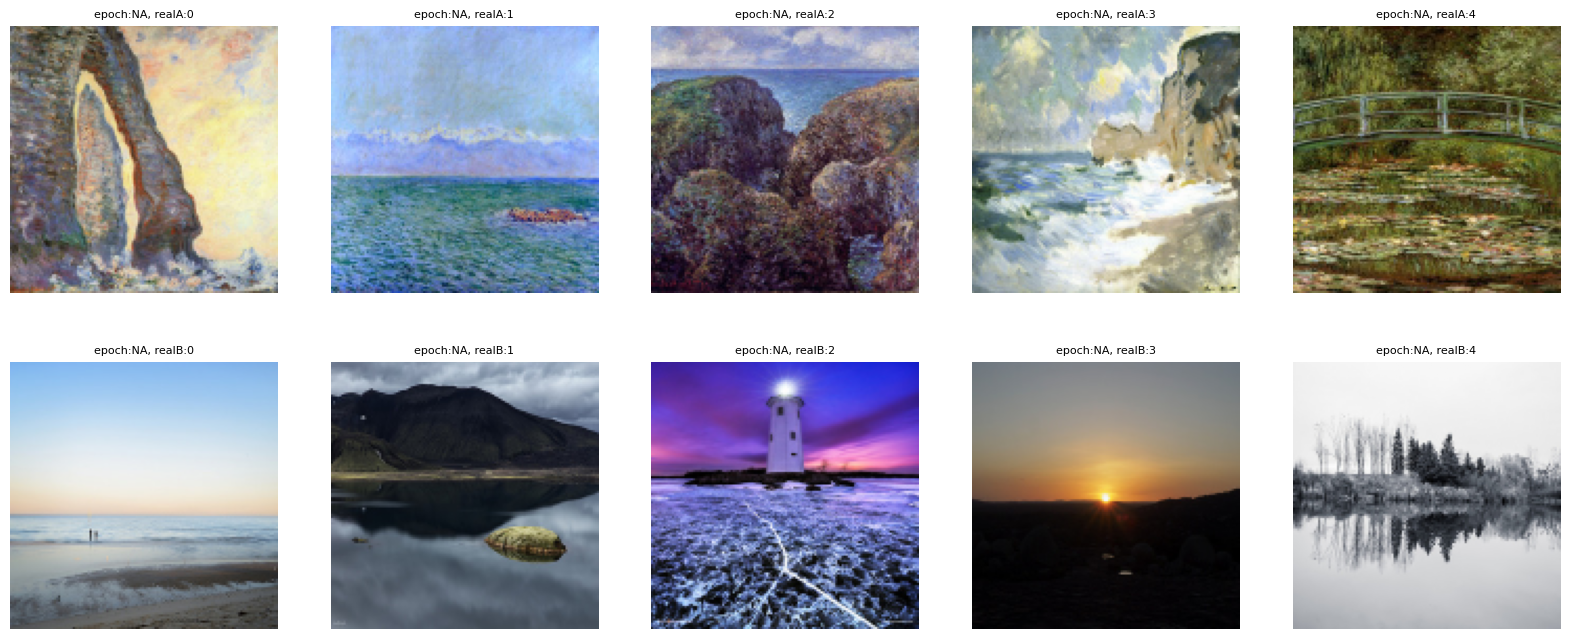

In [4]:
def print_images(imgsA, imgsB, num_to_print=3, figsize=(7.5,7.5), epoch='NA', labels=['fakeA', 'fakeB']):
    fig, ax = plt.subplots(2,num_to_print, figsize=figsize)
    for i in range(num_to_print):
        img = imgsA[i].squeeze(0).permute(1,2,0).numpy().clip(0,1)
        ax[0,i].imshow(img)
        ax[0,i].set_title(f"epoch:{epoch}, {labels[0]}:{i}", size=8)
        ax[0,i].axis('off')
    for i in range(num_to_print):
        img = imgsB[i].squeeze(0).permute(1,2,0).numpy().clip(0,1)
        ax[1,i].imshow(img)
        ax[1,i].set_title(f"epoch:{epoch}, {labels[1]}:{i}", size=8)
        ax[1,i].axis('off')
    plt.show()


imgs_iter = iter(train_dataloader)
imgs = next(imgs_iter)
imgs_monet = imgs[0]
imgs_photos = imgs[1]
print_images(imgs_monet, imgs_photos, num_to_print=5, figsize=(20,8), labels=['realA', 'realB'])

# Generator (ResNet)

In [5]:
class generator_cycle_gan(nn.Module):

  def __init__(self, input_channels, generator_channels, generator_kernels, generator_strides, generator_padding):
    super(generator_cycle_gan, self).__init__()

    # encoder
    self.D0 = self.block_conv7s1(input_channels, generator_channels[0], generator_kernels[0], generator_strides[0], 
                                  generator_padding[0], False)
    self.D1 = self.downsample_block(1, generator_channels[0], generator_channels[1], generator_kernels[1], 
                                    generator_strides[1], generator_padding[1])
    self.D2 = self.downsample_block(2, generator_channels[1], generator_channels[2], generator_kernels[2], 
                                    generator_strides[2], generator_padding[2])
    
    # residual layers
    self.R1 = self.residual_block(in_channels=generator_channels[2], out_channels=generator_channels[2])
    self.R2 = self.residual_block(in_channels=generator_channels[2], out_channels=generator_channels[2])
    self.R3 = self.residual_block(in_channels=generator_channels[2], out_channels=generator_channels[2])
    self.R4 = self.residual_block(in_channels=generator_channels[2], out_channels=generator_channels[2])
    self.R5 = self.residual_block(in_channels=generator_channels[2], out_channels=generator_channels[2])
    self.R6 = self.residual_block(in_channels=generator_channels[2], out_channels=generator_channels[2])
    self.R7 = self.residual_block(in_channels=generator_channels[2], out_channels=generator_channels[2])
    self.R8 = self.residual_block(in_channels=generator_channels[2], out_channels=generator_channels[2])
    self.R9 = self.residual_block(in_channels=generator_channels[2], out_channels=generator_channels[2])

    # decoder
    self.U2 = self.upsample_block(2, generator_channels[2], generator_channels[1], generator_kernels[2], 
                                  generator_strides[2], 1)
    self.U1 = self.upsample_block(1, generator_channels[1], generator_channels[0], generator_kernels[1], 
                                  generator_strides[1], 1)
    self.U0 = self.block_conv7s1(generator_channels[0], input_channels, generator_kernels[0], 
                                 generator_strides[0], generator_padding[0], True)


  def downsample_block(self, i, in_channels, out_channels, kernel_size, stride, padding,): 
    block = nn.Sequential()
    block.add_module(f'down_conv_{i}', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                     kernel_size=kernel_size, padding=padding, 
                                     stride=stride))
    block.add_module(f'down_norm_{i}',nn.InstanceNorm2d(num_features=out_channels))
    block.add_module(f'down_activation_{i}', nn.ReLU())
    return block


  def upsample_block(self, i, in_channels, out_channels, kernel_size, stride, padding): 
    block = nn.Sequential()
    block.add_module(f'up_tconv_{i}', nn.ConvTranspose2d(in_channels=in_channels, 
                                               out_channels=3 if i == 0 else out_channels, kernel_size=kernel_size,
                                               stride=stride, padding=1, output_padding=padding))
    block.add_module(f'up_norm_{i}',nn.InstanceNorm2d(num_features=out_channels))
    block.add_module(f'up_activation_{i}', nn.ReLU())
    return block


  def block_conv7s1(self, in_channels, out_channels, kernel_size, stride, padding, final):
    block = nn.Sequential()
    block.add_module('padding', nn.ReflectionPad2d(3))
    block.add_module('7conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                        kernel_size=kernel_size, padding=padding, stride=stride))
    if final:
        block.add_module(f'7conv_activation', nn.Tanh())
    else:
        block.add_module(f'7conv_norm',nn.InstanceNorm2d(num_features=out_channels))
        block.add_module(f'7conv_activation', nn.ReLU())
    return block

  
  def residual_block(i, in_channels, out_channels):
      block = nn.Sequential()
      block.add_module('padding1', nn.ReflectionPad2d(2))
      block.add_module('residual_conv1_{i}', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                 kernel_size=3, stride=1, padding=0))
      block.add_module('residual_norm1_{i}', nn.InstanceNorm2d(out_channels))
      block.add_module('residual_act_{i}', nn.ReLU())
      block.add_module('padding1', nn.ReflectionPad2d(2))
      block.add_module('residual_conv2_{i}', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                 kernel_size=3, stride=1, padding=0))
      block.add_module('residual_norm2_{i}', nn.InstanceNorm2d(out_channels))     
      return block
  

  def forward(self, x):
    d1 = self.D0(x)
    d2 = self.D1(d1)
    d3 = self.D2(d2)
    r1 = self.R1(d3)
    r2 = self.R2(torch.add(r1, d3))
    r3 = self.R3(torch.add(r2, r1))
    r4 = self.R4(torch.add(r3, r2))
    r5 = self.R5(torch.add(r4, r3))    
    r6 = self.R6(torch.add(r5, r4))
    r7 = self.R7(torch.add(r6, r5))
    r8 = self.R8(torch.add(r7, r6))
    r9 = self.R9(torch.add(r8, r7))
    u2 = self.U2(r9)
    u1 = self.U1(u2)
    u0 = self.U0(u1)
    return u0


  def test(self, device):
    x = torch.rand((5, 3, 128, 128)).to(device)
    y = self.forward(x)
    print(y.shape)



generator_channels = [32, 64, 128]
generator_strides = [1, 2, 2, 2]
generator_padding = [0,1,1,1]
generator_kernels = [7, 3, 3]
input_channels = 3

my_gen = generator_cycle_gan(input_channels, generator_channels, generator_kernels, 
                             generator_strides, generator_padding)
my_gen = my_gen.to(device)
my_gen.test(device)
summary(my_gen, input_size=(3, 128, 128))

imgs_photos_generated = my_gen(imgs_monet.to(device))
print(imgs_monet.shape)
print(imgs_photos_generated.shape)


torch.Size([5, 3, 128, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 134, 134]               0
            Conv2d-2         [-1, 32, 128, 128]           4,736
    InstanceNorm2d-3         [-1, 32, 128, 128]               0
              ReLU-4         [-1, 32, 128, 128]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
    InstanceNorm2d-6           [-1, 64, 64, 64]               0
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
    InstanceNorm2d-9          [-1, 128, 32, 32]               0
             ReLU-10          [-1, 128, 32, 32]               0
  ReflectionPad2d-11          [-1, 128, 36, 36]               0
           Conv2d-12          [-1, 128, 34, 34]         147,584
   InstanceNorm2d-13          [-1, 128, 34, 34]               0
          

# Discriminator

In [6]:
class discriminator_cycle_gan(nn.Module):
    def __init__(self, in_channels, discriminator_channels, discriminator_stride, discriminator_kernel, discriminator_padding):
      super(discriminator_cycle_gan, self).__init__()
      self.layers = nn.Sequential()

      self.layers.add_module('conv0', nn.Conv2d(in_channels=in_channels, out_channels=discriminator_channels[0], 
                                                stride=discriminator_stride[0], kernel_size=discriminator_kernel[0], 
                                                padding=discriminator_padding[0]))
      self.layers.add_module('act0', nn.ReLU())
      self.add_conv_block(['conv1', 'norm1', 'act1'], discriminator_channels[0], discriminator_channels[1], discriminator_stride[1], discriminator_kernel[1], discriminator_padding[1])
      self.add_conv_block(['conv2', 'norm2', 'act2'], discriminator_channels[1], discriminator_channels[2], discriminator_stride[2], discriminator_kernel[2], discriminator_padding[2])
      self.add_conv_block(['conv3', 'norm3', 'act3'], discriminator_channels[2], discriminator_channels[3], discriminator_stride[3], discriminator_kernel[3], discriminator_padding[3])
      self.layers.add_module('conv4', nn.Conv2d(in_channels=discriminator_channels[3], out_channels=discriminator_channels[4], 
                                                stride=discriminator_stride[4], kernel_size=discriminator_kernel[4], 
                                                padding='same'))
      self.layers.add_module('act', nn.Sigmoid())

    def add_conv_block(self, names, in_channels, out_channels, stride, kernel_size, padding):
      self.layers.add_module(names[0], nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                                stride=stride, kernel_size=kernel_size, padding=padding))
      self.layers.add_module(names[1], nn.InstanceNorm2d(num_features=out_channels))
      self.layers.add_module(names[2], nn.ReLU())


    def forward(self, x):
      return self.layers(x)

    def test(self, device):
      x = torch.rand((10, 3, 128, 128)).to(device)
      y = self.forward(x)
      print(y.shape)

discriminator_channels = [32, 64, 128, 256, 1]
discriminator_stride = [2, 2, 2, 2, 1]
discriminator_kernel = [4, 4, 4, 4, 4]
discriminator_padding = [1, 1, 1, 1, 3]
in_channels = 3
my_disc = discriminator_cycle_gan(in_channels, discriminator_channels, discriminator_stride, 
                                  discriminator_kernel, discriminator_padding)
my_disc = my_disc.to(device)

my_disc.test(device)
summary(my_disc, input_size=(3,128,128))



torch.Size([10, 1, 8, 8])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,568
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          32,832
    InstanceNorm2d-4           [-1, 64, 32, 32]               0
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 16, 16]         131,200
    InstanceNorm2d-7          [-1, 128, 16, 16]               0
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9            [-1, 256, 8, 8]         524,544
   InstanceNorm2d-10            [-1, 256, 8, 8]               0
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12              [-1, 1, 8, 8]           4,097
          Sigmoid-13              [-1, 1, 8, 8]               0
Total params:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


# Cycle GAN = 2 discriminators and 2 generators for images from A/B

In [9]:
disc_A = discriminator_cycle_gan(in_channels, discriminator_channels, discriminator_stride, 
                                 discriminator_kernel, discriminator_padding)
disc_B = discriminator_cycle_gan(in_channels, discriminator_channels, discriminator_stride, 
                                 discriminator_kernel, discriminator_padding)

gen_AB = generator_cycle_gan(input_channels, generator_channels, generator_kernels, 
                             generator_strides, generator_padding)

gen_BA = generator_cycle_gan(input_channels, generator_channels, generator_kernels, 
                             generator_strides, generator_padding)

disc_A = disc_A.to(device)
disc_B = disc_B.to(device)
gen_AB = gen_AB.to(device)
gen_BA = gen_BA.to(device)

epochs = range(124)
lambda_reconstr = 10 
lambda_id = 5
lambda_validation = 1
lr = 0.0002

optimizer_disc = Adam(
    list(disc_A.parameters()) + list(disc_B.parameters()), 
    lr=lr,
    betas=(0.5,0.999)
)
optimizer_gen = Adam( 
    list(gen_AB.parameters()) + list(gen_BA.parameters()),
    lr=lr,
    betas=(0.5,0.999)
)

l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
log_disc_loss_batch = []
log_gen_loss_batch = []

start_epoch = 0

# (Optional) Load checkpoint




In [15]:
from google.colab import drive
drive.mount('/content/drive/')

checkpoint = torch.load('/content/drive/My Drive/Models/cycleGAN_monet_epoch123.pt')

disc_A.load_state_dict(checkpoint['disc_A_state_dict'])
disc_B.load_state_dict(checkpoint['disc_B_state_dict'])
gen_AB.load_state_dict(checkpoint['gen_AB_state_dict'])
gen_BA.load_state_dict(checkpoint['gen_BA_state_dict'])

optimizer_disc.load_state_dict(checkpoint['opt_disc_state_dict'])
optimizer_gen.load_state_dict(checkpoint['opt_gen_state_dict'])

epoch = checkpoint['epoch']
fakeA = checkpoint['fakeA']
fakeB = checkpoint['fakeB']


start_epoch = 124
epochs = range(124, 150)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Traning (need to train for a lot longer)



In [ ]:

for e in epochs:

  ######### Training
  progress_bar = tqdm(train_dataloader, desc=f'Training epoch: {e}')
  i = 0
  print(f'epoch:{e}')
  total_train_g_loss=total_train_id_loss=total_train_reconstr_loss=total_train_valid_loss=0
  total_train_loss_disc=total_train_dA_loss=total_train_dB_loss=0
  for batch_idx, (imgsA, imgsB) in enumerate(progress_bar):

    i += 1
    imgsA = imgsA.to(device)
    imgsB = imgsB.to(device)

    # train discriminator A and B
    gen_AB.eval()
    gen_BA.eval()
    disc_A.train()
    disc_B.train()
    dA_y_hat_real = disc_A(imgsA)
    fakeA = gen_BA(imgsB)
    dA_y_hat_fake = disc_A(fakeA.detach())
    y_real = torch.ones_like(dA_y_hat_real)
    y_fake = torch.zeros_like(dA_y_hat_fake)
    dA_loss = mse_loss(dA_y_hat_real, y_real) + mse_loss(dA_y_hat_fake, y_fake) 

    dB_y_hat_real = disc_B(imgsB)
    fakeB = gen_AB(imgsA)
    dB_y_hat_fake = disc_B(fakeB.detach())
    y_real = torch.ones_like(dB_y_hat_real)
    y_fake = torch.zeros_like(dB_y_hat_fake)
    dB_loss = mse_loss(dB_y_hat_real, y_real) + mse_loss(dB_y_hat_fake, y_fake) 

    if e == start_epoch and i == 1:
      print_images(fakeA.detach().cpu(), fakeB.detach().cpu(), num_to_print=3, figsize=(12,8), epoch=start_epoch)

    d_loss = dA_loss + dB_loss
    optimizer_disc.zero_grad()
    d_loss.backward()
    optimizer_disc.step()
    log_disc_loss_batch.append(d_loss.item())


    # train generators AB and BA
    gen_AB.train()
    gen_BA.train()
    disc_A.eval()
    disc_B.eval()
    validA = disc_A(fakeA)
    validA_loss = mse_loss(validA, torch.ones_like(validA))
    validB = disc_B(fakeB)
    validB_loss = mse_loss(validB, torch.ones_like(validB))
    valid_loss = validA_loss + validB_loss

    reconstrA = gen_BA(fakeB)
    reconstrA_loss = l1_loss(reconstrA, imgsA)
    reconstrB = gen_AB(fakeA)
    reconstrB_loss = l1_loss(reconstrB, imgsB)
    reconstr_loss = reconstrA_loss + reconstrB_loss
    
    idA = gen_BA(imgsA)
    idA_loss = l1_loss(idA, imgsA)
    idB = gen_AB(imgsB)
    idB_loss = l1_loss(idB, imgsB)
    id_loss = idA_loss + idB_loss


    g_loss = lambda_validation * valid_loss + lambda_reconstr * reconstr_loss + lambda_id * id_loss
    optimizer_gen.zero_grad()
    g_loss.backward()
    optimizer_gen.step()
    log_gen_loss_batch.append(g_loss.item())

    # Train Stats
    total_train_g_loss += g_loss.item()
    total_train_id_loss += id_loss.item()
    total_train_reconstr_loss += reconstr_loss.item()
    total_train_valid_loss += valid_loss.item()
    total_train_loss_disc += d_loss.item()
    total_train_dA_loss += dA_loss.item()
    total_train_dB_loss += dB_loss.item()

    progress_bar.set_postfix(
        gen_loss=total_train_g_loss/(batch_idx+1), 
        id=total_train_id_loss/(batch_idx+1), 
        adv=total_train_valid_loss/(batch_idx+1), 
        cycle=total_train_reconstr_loss/(batch_idx+1),
        disc_loss=total_train_loss_disc/(batch_idx+1), 
        disc_a=total_train_dA_loss/(batch_idx+1), 
        disc_b=total_train_dB_loss/(batch_idx+1)
    )

  ####### TESTING
  total_test_g_loss = total_test_id_loss = total_test_reconstr_loss = total_test_valid_loss = 0
  total_test_disc_loss=total_test_discA_loss=total_test_discB_loss=0
  test_progress_bar = tqdm(test_dataloader, desc=f'Testing epoch {e}', total=int(len(test_dataloader)))
  for batch_idx, (test_imgsA, test_imgsB) in enumerate(test_progress_bar):
    test_imgsA = test_imgsA.to(device)
    test_imgsB = test_imgsB.to(device)

    # test Generators
    gen_AB.eval()
    gen_BA.eval()
    
    test_idA_loss = l1_loss(gen_BA(test_imgsA), test_imgsA)
    test_idB_loss = l1_loss(gen_BA(test_imgsB), test_imgsB)
    test_id_loss = test_idA_loss + test_idB_loss

    test_reconstrA_loss = l1_loss(gen_BA(gen_AB(test_imgsA)), test_imgsA)
    test_reconstrB_loss = l1_loss(gen_AB(gen_BA(test_imgsA)), test_imgsB)
    test_reconstr_loss = test_reconstrA_loss + test_reconstrB_loss

    fakeB = gen_AB(test_imgsA)
    test_validA_loss = mse_loss(disc_B(fakeB), torch.ones_like(disc_B(fakeB)))
    fakeA = gen_BA(test_imgsB)
    test_validB_loss = mse_loss(disc_B(fakeA), torch.ones_like(disc_B(fakeA)))
    test_valid_loss = test_validA_loss + test_validB_loss

    test_g_loss = lambda_validation * test_valid_loss + lambda_reconstr * test_reconstr_loss + lambda_id * test_id_loss

    # test Discriminators
    disc_A.eval()
    disc_B.eval()
    test_discA_loss = mse_loss(disc_A(fakeA), torch.zeros_like(disc_A(fakeA))) +  mse_loss(disc_A(test_imgsA), torch.zeros_like(disc_A(test_imgsA)))
    test_discB_loss = mse_loss(disc_B(fakeB), torch.zeros_like(disc_B(fakeB))) +  mse_loss(disc_B(test_imgsB), torch.zeros_like(disc_B(test_imgsB)))
    test_disc_loss = test_discA_loss + test_discB_loss
    disc_B(fakeB)
        
    # Test stats
    total_test_g_loss += test_g_loss.item()
    total_test_id_loss += test_id_loss.item()
    total_test_reconstr_loss += test_reconstr_loss.item()
    total_test_valid_loss += test_valid_loss.item()
    total_test_disc_loss += test_disc_loss.item()
    total_test_discA_loss += test_discA_loss.item()
    total_test_discB_loss += test_disc_loss.item()
    test_progress_bar.set_postfix(
        gen_loss=total_test_g_loss/(batch_idx+1), 
        id=total_test_id_loss/(batch_idx+1), 
        adv=total_test_valid_loss/(batch_idx+1), 
        cycle=total_test_reconstr_loss/(batch_idx+1),
        disc_loss=total_test_disc_loss/(batch_idx+1), 
        disc_a=total_test_discA_loss/(batch_idx+1), 
        disc_b=total_test_discB_loss/(batch_idx+1)
    )

  # save checkpoint
  if e % 3 == 0:
    torch.save({
            'epoch': e,
            'disc_A_state_dict': disc_A.state_dict(),
            'disc_B_state_dict': disc_B.state_dict(),
            'gen_AB_state_dict': gen_AB.state_dict(),
            'gen_BA_state_dict': gen_BA.state_dict(),
            'opt_disc_state_dict': optimizer_disc.state_dict(),
            'opt_gen_state_dict': optimizer_gen.state_dict(),
            'train_gen_loss': total_train_g_loss/(batch_idx+1), 
            'train_id_loss': total_train_id_loss/(batch_idx+1), 
            'train_adv_loss': total_train_valid_loss/(batch_idx+1), 
            'train_cycle_loss': total_train_reconstr_loss/(batch_idx+1),
            'train_disc_loss': total_train_loss_disc/(batch_idx+1), 
            'train_disc_a_loss': total_train_dA_loss/(batch_idx+1), 
            'train_disc_b_loss': total_train_dB_loss/(batch_idx+1),
            'test_gen_loss': total_test_g_loss/(batch_idx+1), 
            'test_id_loss': total_test_id_loss/(batch_idx+1), 
            'test_adv_loss': total_test_valid_loss/(batch_idx+1), 
            'test_cycle_loss': total_test_reconstr_loss/(batch_idx+1),
            'test_disc_loss': total_test_disc_loss/(batch_idx+1), 
            'test_disc_a_loss': total_test_discA_loss/(batch_idx+1), 
            'test_disc_b_loss': total_test_discB_loss/(batch_idx+1),
            'fakeA': fakeA.detach().cpu()[0:5],
            'fakeB': fakeB.detach().cpu()[0:5],
            }, f'/content/drive/My Drive/Models/cycleGAN_monet_epoch{e}.pt')

  # Print fake images at end of each epoch
  print_images(fakeA.detach().cpu(), fakeB.detach().cpu(), num_to_print=3, figsize=(12,8), epoch=e)

# Side by side comparison of fake and real train/test images for A/B after training


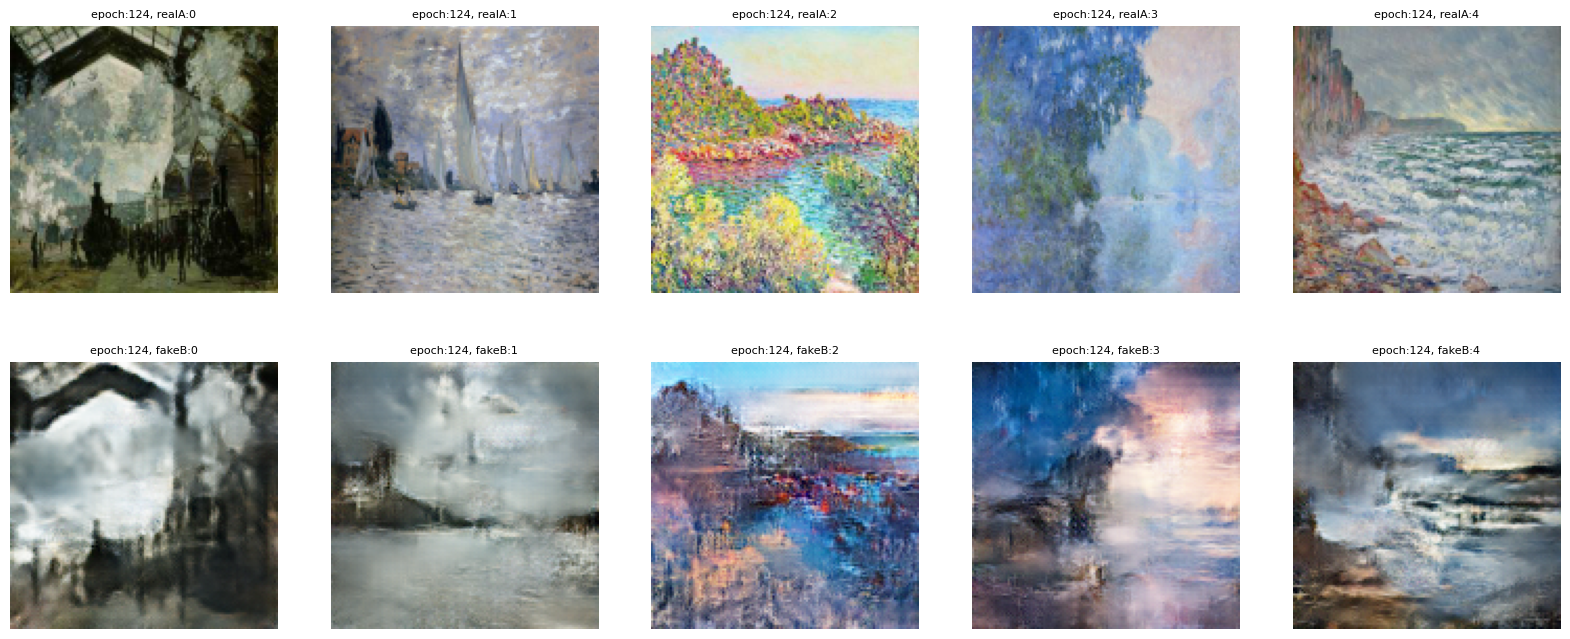

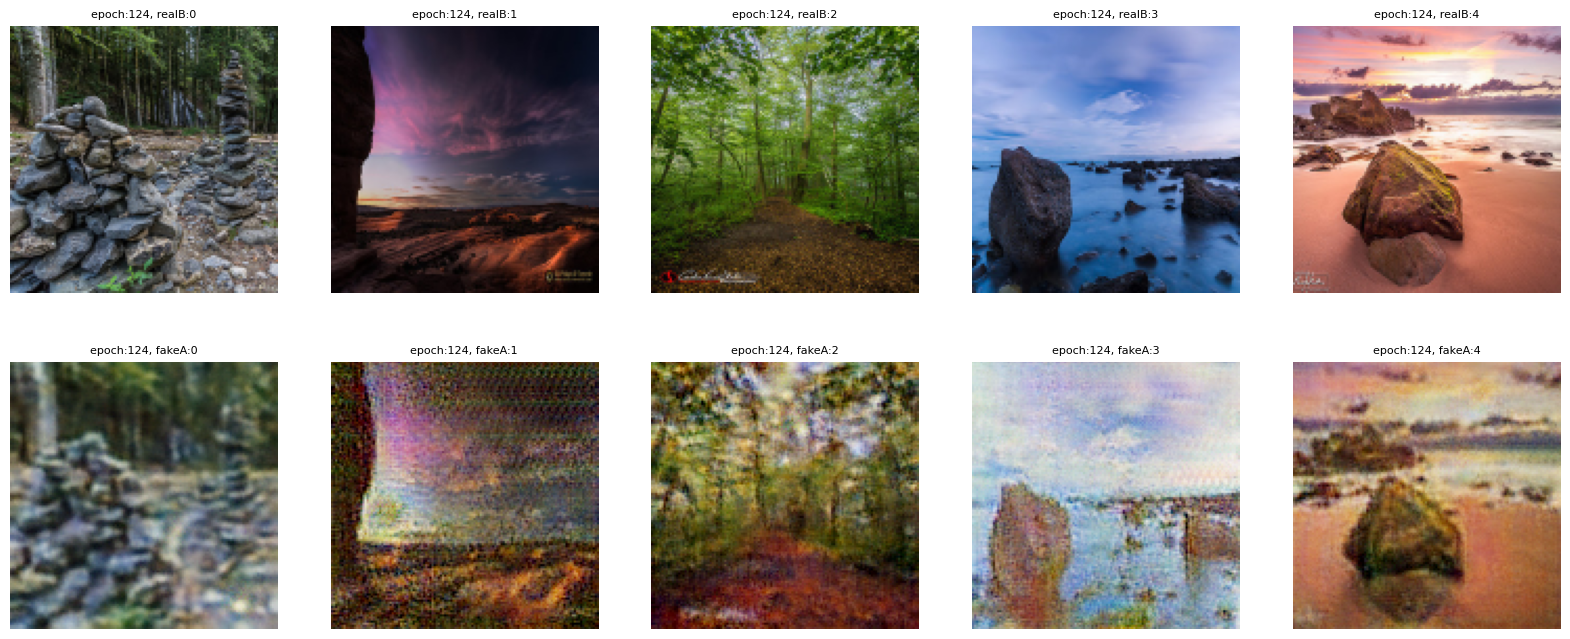

In [22]:
imgs_iter = iter(test_dataloader)
imgs = next(imgs_iter)
imgs_monet = imgs[0]
imgs_pics = imgs[1]
fake_monet = gen_BA(imgs_pics.to(device)).detach().cpu()
fake_pics = gen_AB(imgs_monet.to(device)).detach().cpu()
print_images(imgs_monet, fake_pics, num_to_print=5, figsize=(20,8), epoch=e, labels=['realA', 'fakeB'])
print_images(imgs_pics, fake_monet, num_to_print=5, figsize=(20,8), epoch=e, labels=['realB', 'fakeA'])



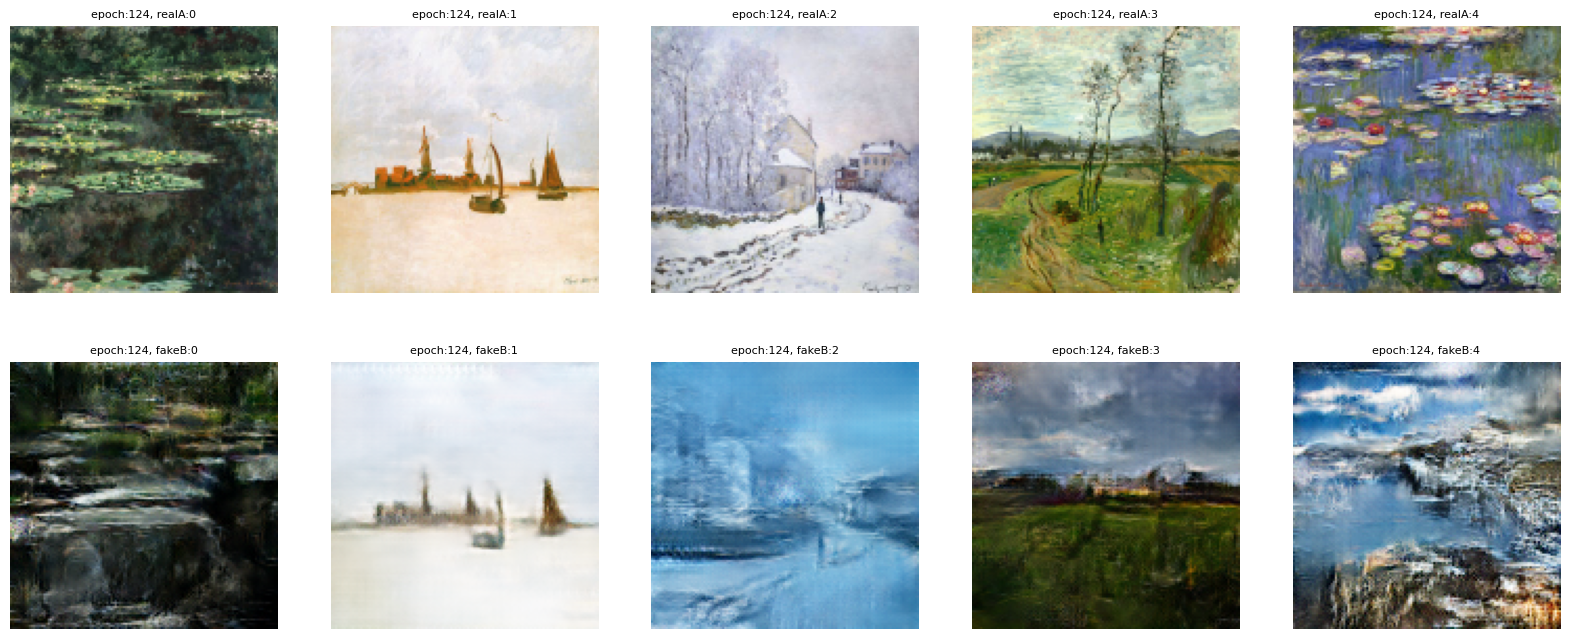

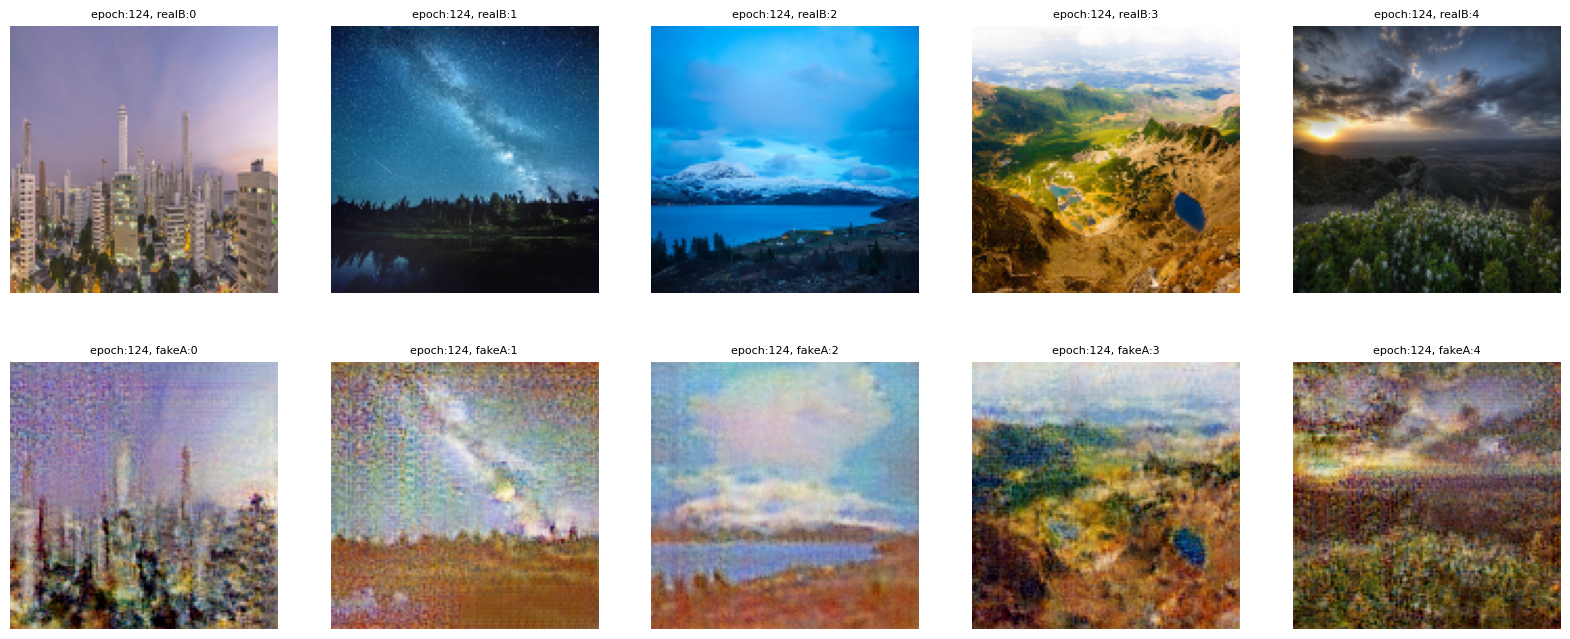

In [23]:
imgs_iter = iter(train_dataloader)
imgs = next(imgs_iter)
imgs_monet = imgs[0]
imgs_pics = imgs[1]
fake_monet = gen_BA(imgs_pics.to(device)).detach().cpu()
fake_pics = gen_AB(imgs_monet.to(device)).detach().cpu()
print_images(imgs_monet, fake_pics, num_to_print=5, figsize=(20,8), epoch=e, labels=['realA', 'fakeB'])
print_images(imgs_pics, fake_monet, num_to_print=5, figsize=(20,8), epoch=e, labels=['realB', 'fakeA'])

